In [4]:
import numpy as np

In [5]:
import zipfile
from shutil import copyfile
import glob
import re
import h5py
import green2
import json
import os
import fnmatch

In [6]:
from BachataClass_upd import *
from wavesensors import *
from wavesource import *

ModuleNotFoundError: No module named 'wavesensors'

In [25]:
#!/usr/bin/env python3
import numpy as np
from pandas.api.types import is_list_like, is_dict_like

# ---------------------------------------------------------------------------
# Planar array of sensors (geometrical parameters and sensors location points)
# ---------------------------------------------------------------------------
class wavesensors(object):
    def __init__(self, domain=None, dxy=None, xx=None, nsensors=None):
        '''
        Sensors mesh object
        
        Input:
        domain 		-- dimensions, list of values [xmin, xmax, ymin, ymax]
        nsensors 	-- number of sensors,list of integers [nx, ny]
        xx (optional)	-- coordinates of sensors, list with shape (n, 3)
        dxy (optional)	-- sensors placing step, list of values [dx, dy]
        
        z coordinates of sensors is assumed to be 0
        
        Either nsensors or dxy must be given, not together
        If both nsensors and dxy not are not provided then assumed dxy = [size_x, size_y]
        '''
        
        #if all(v is None for v in [hypocenter, size, xx, dx]):
        #    raise ValueError("All None: Either hypocenter or source points must be given")
        if xx is not None:
            self.coords = xx
        elif domain is not None:
            self.domain = domain
            if nsensors is None:
                if dxy is not None:
                    self.dx = dxy
                else:
                    self.dx = self.size
                
            elif dxy is None:
                self.nsensors = nsensors
                self.dx = self.size / (nsensors + (nsensors==1) - 1)
            else:
                raise ValueError("Either nsensors or sensors placing step must be given, not both")
                
            self.discretize()
        else:
            raise ValueError("Either sensors domain or sensors points must be given")
            
    @property
    def domain(self):
        return self._domain
        #else:
        #    coords = self.coords[:,0:2]
        #    return np.hstack(coords.min(),coords.max())
        
    @domain.setter
    def domain(self, domain):
        if is_list_like(domain):
            if is_dict_like(domain):
                mykeys = sorted(domain, key=limits)
                domain = np.array([domain[i] for i in mykeys],dtype=float)
            else:
                domain = np.array(domain,dtype=float)
            if len(domain)==4:
                domain = domain.reshape(2,2)
                self._domain = domain
                self.size = domain[:,1] - domain[:,0]
            
                if any(self.size < 0):
                    raise ValueError("Size of domain must be non-negative")
            else:
                raise ValueError("Domain constraint should have the format [xa,xb,ya,yb]")
        else:
            TypeError("Domain constraint should be listlike object")
            
    @property
    def size(self):
        return self._size
        
    @size.setter
    def size(self, size):
        self._size = size
    
    @property
    def nsensors(self):
        return self._nsensors
        
    @nsensors.setter
    def nsensors(self, nsensors):
        if is_list_like(nsensors):
            if len(nsensors)==2:
                if is_dict_like(nsensors):
                    nsensors = np.array([nsensors[i] for i in sorted(nsensors, key=str.lower)], dtype=int)
                else:
                    nsensors = np.array(nsensors, dtype=int)
                #nsensors = nsensors + (nsensors==1)
                self._nsensors = nsensors[0]*nsensors[1]
                
                if any(nsensors < 1):
                    raise ValueError("Sensors number must not be less than 1")
            else:
                raise ValueError("nsensors should have the format [nx,ny]")
        else:
            TypeError("nsensors should be listlike object")
            
    @property
    def dx(self):
        return self._dx
    
    @dx.setter
    def dx(self, dxy):
        if is_list_like(dxy):
            if len(dxy)==2:
                if is_dict_like(dxy):
                    dxy = np.array([dxy[i] for i in sorted(dxy, key=str.lower)], dtype=float)
                else:
                    dxy = np.array(dxy, dtype=float)
                self._dx = dxy*(dxy > 0) + (dxy==0)*self.size
                
                if any(dxy < 0):
                    raise ValueError("Discretization mesh cell size must be non-negative")
            else:
                raise ValueError("dxy should have the format [dx,dy]")
        else:
            raise TypeError("dxy should be listlike object")
        
    @property
    def coords(self):
        return self._coords
    
    @coords.setter
    def coords(self, xx):
        if xx is not None:
            if is_list_like(xx) and (3 in np.shape(xx)):
                self._coords = np.array(xx,dtype='d')
            else:
                raise TypeError("Sensor points coordinates must be list like and (n,3)-shaped")           
    
    
    def discretize(self):
        nx = self.size/self.dx
        ni = [int(i) for i in nx]
        #padd = self.size - nix*self.dx
        
        #l = ni*self.dx 	#self.size - padd
        #self.nsensors = np.array(ni) + 1
            
        x = np.linspace(self.domain[0,0], self.domain[0,1], ni[0] + 1)
        y = np.linspace(self.domain[1,0], self.domain[1,1], ni[1] + 1)
        self.nsensors = [len(x),len(y)]
           
        g = np.meshgrid(x,y)
        loc = np.vstack(list(map(np.ravel, g))).T
        #print(loc)
        #print(self.nsensors)
        self.coords = np.hstack((loc,np.zeros((self.nsensors,1))))
        #self.domain = np.hstack((loc.min(),loc.max()))

In [26]:
#!/usr/bin/env python3
import numpy as np
from pandas.api.types import is_list_like, is_dict_like

# ---------------------------------------------------------------------------
# Volumetric Source of seismic waves (geometrical parameters, mesh and tensor)
# ---------------------------------------------------------------------------
class wavesource(object):
    def __init__(self, hypocenter=None, size=0, xx=None, dx=None, form='sphere', random=False):
        '''
        Source of waves object
        
        Input:
        hypocenter 	-- source location, list of values [x, y, z]
        size (optional)	-- source size, number (default 0)
        xx (optional)	-- coordinates of source, list with shape (n, 3)
        dx (optional)	-- source mesh step, number (default is the same as size)
        form (optional) -- 'sphere' for spherical source, otherwise cubic
        random   	-- if True irregular mesh, if False regular 3D mesh
        
        Either hypocenter or xx must be given
        '''
        if xx is not None:
            self.coords = xx
            self.origin = self.hypocenter()
        elif hypocenter is not None:
            self.origin = hypocenter
            if size is not None:
                self.size = size
                if dx is not None:
                    self.dx = dx
                else:
                    self.dx = 2*size
            else:
                self.size = 0
                self.dx = size
                
            self.discretize(form, random)
        else:
            raise ValueError("Either hypocenter or source points must be given")
        self.source_points()
                
            
    @property
    def origin(self):
        return self._origin
        
    @origin.setter
    def origin(self, hypocenter):
        if is_list_like(hypocenter) and (len(hypocenter) == 3):
            if is_dict_like(hypocenter):
                mykeys = sorted(hypocenter, key=str.lower)
                self._origin = np.array([hypocenter[i] for i in mykeys], dtype=float)
                #self._origin = np.array([hypocenter['x'],hypocenter['y'],hypocenter['z']])

            #hypocenter = hypocenter.values() if is_dict_like(hypocenter) else hypocenter
            else:
                self._origin = np.array(hypocenter, dtype=float)
        else:
            raise TypeError("Hypocenter coordinates must be a numeric listlike object [x0,y0,z0]")
        
    @property
    def size(self):
        if self._size is not None:
            return self._size
        else:
            return self.source_dims()
        
    @size.setter
    def size(self, size):
        if size is not None:
            size = float(size)
            if size >= 0:
                self._size = size
            else:
                raise ValueError("Size of source must be non-negative")
        else:
            self._size = size
        
    @property
    def coords(self):
        return self._coords
    
    @coords.setter
    def coords(self, xx):
        if xx is not None:
            if is_list_like(xx) and (3 in np.shape(xx)):
                self._coords = np.array(xx,dtype='d')
            else:
                raise TypeError("Source points coordinates must be list like and (n,3)-shaped")           
    
    @property
    def dx(self):
        return self._dx
    
    @dx.setter
    def dx(self, dx):
        dx = float(dx)
        if dx < 0:
            raise ValueError("Discretization mesh cell size must be non-negative")
        else:
            self._dx = dx*(dx > 0) + self.size*(dx==0)
    
    def discretize(self, form, random):
        #nx = self.size/self.dx
        nix = int(self.size/self.dx)
        #padd = self.size - nix*self.dx
        
        if random:
            xx = (np.random.rand(nix**3,3)-0.5)*self.size + self.origin
        else:
            lx = nix*self.dx 	#self.size - padd
            #nix = nix*(nix>0) + (nix==0)
            
            #xmin = self.origin[0]-lx/2; xmax = self.origin[0]+lx/2
            #ymin = self.origin[1]-lx/2; ymax = self.origin[1]+lx/2
            #zmin = self.origin[2]-lx/2; zmax = self.origin[2]+lx/2
            
            x = np.linspace(self.origin[0]-lx/2, self.origin[0]+lx/2, nix+1)
            y = np.linspace(self.origin[1]-lx/2, self.origin[1]+lx/2, nix+1)
            z = np.linspace(self.origin[2]-lx/2, self.origin[2]+lx/2, nix+1)
           
            g = np.meshgrid(x,y,z)
            xx = np.vstack(list(map(np.ravel, g))).T
            #print(xx)
           
        if form == 'sphere':
            self._coords = xx[np.linalg.norm(xx-self.origin[None,:],axis=1) <= self.size/2,:]
        else:
            self._coords = xx
           
           
    def hypocenter(self): 
        return self.coords.mean(axis=0)
        
    def source_dims(self):
        self.dims = self.coords.max(axis=0) - self.coords.min(axis=0)
        return self.dims
        
    def source_radius(self):
        self.radius = np.linalg.norm(self.coords,axis=1).std()
        return self.radius
        
    def source_points(self):
        self.npoints = self.coords.shape[0]
        return self.npoints
    
    def source_gridcellsize(self):
        gridcellsize = [np.diff(np.unique(self.coords[:,i])).mean() for i in range(3)]
        self.xarray = np.unique(self.coords[:,0])
        self.yarray = np.unique(self.coords[:,1])
        self.zarray = np.unique(self.coords[:,2])
        print(gridcellsize)
        
    #def source_grid(self):
    #     = self.coords.shape
    #    grid = self.dims
    #    return
    
    @property
    def mtensor(self):
        return self._mtensor
    
    @mtensor.setter    
    def mtensor(self, tensor):
        if is_list_like(tensor):
            if len(tensor)==6:
                self._mtensor = np.array(tensor, dtype=float)
            elif np.shape(tensor)==(3,3):
                self._mtensor = np.reshape(tensor, 9)[[0,4,8,1,2,5]]
            else:
                raise ValueError("Incorrect shape of seismic tensor: should be (6,) or (3,3)")
        else:
            raise TypeError("Seismic tensor must be a list of numbers")

In [27]:
from rndflow import job

In [28]:
fmin, fmax = 10, 30
xc = 0

In [29]:
# sorting function key
def limits(key_string):
    labels = [['a','low','lower','min','left','down','l','1'],
              ['b','high', 'up','upper','right','max','r','2']]
    
    for i in [0,1]:
        if (key_string.lower()[1:] in labels[i]) or (key_string.lower()[2:] in labels[i]):
            return key_string.lower()[0]+labels[i][0]

In [30]:
#--------------------------------------------------------------------------
#  Read zip file functions
#--------------------------------------------------------------------------
def read_hit_pts(filename):
    
    with open(filename, 'r') as f:
        s = f.readlines()
    f.close()

    res = np.zeros((len(s), 6))
    geo_coords=list()
    names=[]
    
    for i in range(len(s)):
        line=s[i].split()
        res[i, :] = np.array([int(i) for i in line[1:7]])
        geo_coords.append([float(line[8]),float(line[7]),float(line[6])]) # add real X, real Y, depth, changed axis between XY
        names.append(line[0])

    xy_cells = (res[:, 0:2])
    xy_metres = (res[:, 2:4])
    zz = (res[:, 4:])

    return xy_cells, xy_metres, zz, geo_coords, names

In [31]:
#------------------------------------------------------------------------#
#  _____________________________BEGIN__________________________________  #
#------------------------------------------------------------------------#
# Load everything from input package:
globals().update(job.load())    #load variables from input package
globals().update(job.params())  #load parameters from input package
pkg=job.packages()[0]
fields=pkg.fields

In [32]:
files = glob.glob('**',recursive = True)

In [33]:
zip_file = [name for name in files if '.zip' in name]

In [34]:
if len(zip_file)>0:
    try:
        with zipfile.ZipFile(*zip_file) as z:
            z.extractall(os.path.dirname(*zip_file))
            print("Extracted all")
    except:
        print("Invalid file")

In [35]:
cellsize=12

In [36]:
#---------------------------------------
#read source points coordinates
files = glob.glob('**',recursive = True)
source_path=[s for s in files if fnmatch.fnmatch(s, '*.txt')]
source_file=[s for s in source_path if 'points' in s][0]
print('Reading source points coords')
sourcexy_c, sourcexy_m, zz, geo_coords_source, source_names = read_hit_pts(source_file)

Reading source points coords


In [37]:
x_center,y_center=np.mean(np.array(geo_coords_source)[:,:2],axis=0)
print(x_center,y_center)

4455053.0 6085550.0


In [38]:
#test
if np.sum(sourcexy_c*cellsize - sourcexy_m, axis=(0,1)) == 0:
    print('Data is correct!')
else:
    raise ValueError('Source points data is not coherent! Abort...')

ValueError: Source points data is not coherent! Abort...

In [39]:
xy_source = np.append(sourcexy_m, zz[:,1][:,None], axis=1)
del sourcexy_m
print(xy_source)

[[2050. 2040.  900.]]


In [40]:
#---------------------------------------
#read sensors.txt
sensors_path=[s for s in files if 'sensors.txt' in s][0]
print('Reading sensors coords')
sensorxy_c, sensorxy_m, zz, geo_coords_sens,sens_names = read_hit_pts(sensors_path)

Reading sensors coords


In [41]:
print(geo_coords_sens[:3])

[[4454493.0, 6086913.0, 0.0], [4454805.0, 6086797.0, 0.0], [4455184.0, 6086917.0, 0.0]]


In [42]:
#test
if np.sum(sensorxy_c*cellsize - sensorxy_m, axis=(0,1)) == 0:
    print('Data is correct!')
else:
    raise ValueError('Sensors data is not coherent! Abort...')

ValueError: Sensors data is not coherent! Abort...

In [43]:
xy_sensors = np.append(sensorxy_m, zz[:,1][:,None], axis=1)
del sensorxy_m
print(xy_sensors[:3])

[[ 690. 2600.    0.]
 [ 800. 2280.    0.]
 [ 680. 1910.    0.]]


In [44]:
field_lst=list(map(lambda name,coord: [int(name),*coord],sens_names,geo_coords_sens))
print(field_lst[:3])
# ----------------Initialization of source object -------------------------
source = wavesource(xx=xy_source)

[[1001, 4454493.0, 6086913.0, 0.0], [1002, 4454805.0, 6086797.0, 0.0], [1003, 4455184.0, 6086917.0, 0.0]]


In [45]:
# ----------------Initialization of sensors array object ------------------
sensors = wavesensors(xx=xy_sensors)

In [163]:
#----------------Calculation domainX, domainY, domainZ, --------------------
shape=np.unique(xy_source[:,0]).shape[0]
X=np.sort(np.unique(xy_source[:,0]))
Y=np.sort(np.unique(xy_source[:,1]))
Z=np.sort(np.unique(xy_source[:,2]))
width_x=X[shape//2]-X[0]
width_y=Y[shape//2]-Y[0]
domainX=np.linspace((xc-width_x),(xc+width_x),shape)
domainY=np.linspace((xc-width_y),(xc+width_y),shape)
domainZ=Z
#----------------Write data for batchata -----------------------------------
vp=1250
vs=vp/2
fd=500
T=5
Q=30
Nd = 2

sens_geo_coords=np.array(field_lst)[:,1:]
xx=sens_geo_coords-geo_coords_source

# -----------BEFORE CORRECT
rs = green2.response_t(xx, T=T, fs=fd)
rs.make_green(Q=Q, vp=vp, vs=vs, fp=1e7, a3=1e-5, naive=False)

Gtp = rs.Gtp(nD=Nd)
Gts = rs.Gts(nD=Nd)
Gtsum = -Gtp + Gts

data_final=[]
for i in range(sensors.coords.shape[0]):
    data_final.extend(Gtsum[i,[2,0,1],:,:].reshape(3,1,6,rs.N))
# ----------------Initialization of bachata-object -------------------------
filename = f'batch_Q{Q}_VP{vp}_VS{vs}_Nd{Nd}_T{T}_fd{fd}_new.hdf5'

kwargs = {'data_type': 'full_wave_time',
            'channels': ['Z','X','Y'],
            'L': rs.N,
            'fd': fd,
            'xcenter': x_center,
            'ycenter': y_center,
            'grid_step': np.array([cellsize]*3,dtype=int),
            'altitude': np.array([source.origin[2]],dtype=float),
            'mult_degree': np.array([10**power]),
            'sensor': sens_names, 
            'domainX': domainX,
            'domainY': domainY,
            'domainZ': domainZ,
            'field': np.array(field_lst)[:,:3],
            'fmin': rs.ff.min(),
            'fmax': rs.ff.max(),
            'data': data_final 
            }                   # add power 10000 units

print(f'VP {vp}, VS {vs}')
jpath=job.save_package(label=pkg.label)
fpath = str(jpath)+'/files/'
os.mkdir(fpath)

obj = BachataClass(fpath+filename,**kwargs)
print('Done')

VP 1250, VS 625.0
Done


In [164]:
def integral(signal):
    
    integ=[]
    for i in range(1,signal.shape[0]):
        r=(signal[i]+signal[i-1])*fd
        integ.append(r)
    res=np.array(integ)
    return res

In [165]:
# full_mod=h5py.File('batch_obj_0.001.hdf5')
# full_mod['Channels'][sensor]['data'][0,tensor_comp,:].shape

out/16/files/batch_Q30_VP1250_VS625.0_Nd2_T5_fd500_new.hdf5


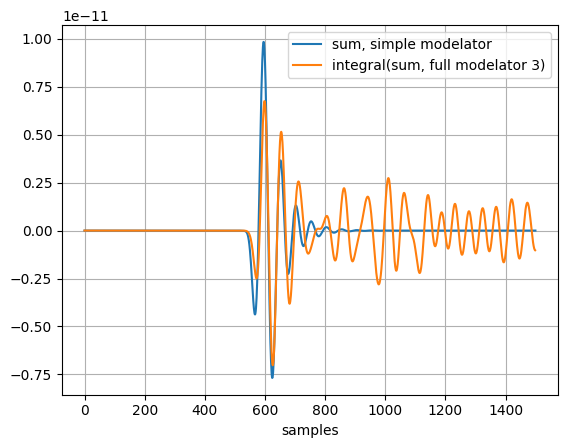

In [169]:
import matplotlib.pyplot as plt
import h5py
from scipy import signal
import glob

sensor='1030_Z'
tensor_comp=2
samples=1500

files = glob.glob('**',recursive = True)
path_to_full_modelator=[f for f in files if filename in f][0]
print(path_to_full_modelator)

simple_mod=h5py.File(path_to_full_modelator)
full_mod_1=h5py.File('batch_obj_0.0005.hdf5') # power=1e4, modelling_step=0.0005 sig_len=5000
full_mod_2=h5py.File('batch_obj_0.001.hdf5')  # power=2e4, modelling_step=0.001 sig_len=5000
full_mod_3=h5py.File('batch_obj.hdf5') # power=1e4, modelling_step=0.001 sig_len=5000

newton_power=1e4
mult_degree=1e11
modelling_step=0.001
grid_step=12
fd=500

k=newton_power*mult_degree*modelling_step*grid_step#*(1/fd)

# simple plot
#plt.plot(simple_mod['Channels'][sensor]['data'][0,tensor_comp,:samples],label='simple modelator')
#plt.plot(full_mod['Channels'][sensor]['data'][0,tensor_comp,:samples],label='full wave modelator')

# centre explosion
sum_simple_mod=np.sum(simple_mod['Channels'][sensor]['data'][0,:3,:samples],axis=0)
sum_full_mod1=np.sum(full_mod_1['Channels'][sensor]['data'][0,:3,:samples],axis=0)
sum_full_mod2=np.sum(full_mod_2['Channels'][sensor]['data'][0,:3,:samples],axis=0)
sum_full_mod3=np.sum(full_mod_3['Channels'][sensor]['data'][0,:3,:samples],axis=0)
#plt.plot(sum_simple_mod,label='sum, simple modelator')
#plt.plot(sum_full_mod,label='sum, full wave modelator')

# filtration
fs=10
sos = signal.butter(10, fs, 'lowpass', fs=fd, output='sos')

plt.plot(signal.sosfilt(sos, sum_simple_mod),label='sum, simple modelator')
#plt.plot(integral(signal.sosfilt(sos, sum_full_mod1)),label="integral(sum, full modelator 1)")
#plt.plot(integral(signal.sosfilt(sos, sum_full_mod2)),label="integral(sum, full modelator 2)")
plt.plot(integral(signal.sosfilt(sos, sum_full_mod3))/k,label="integral(sum, full modelator 3)")

plt.xlabel('samples')
plt.grid()
plt.legend()

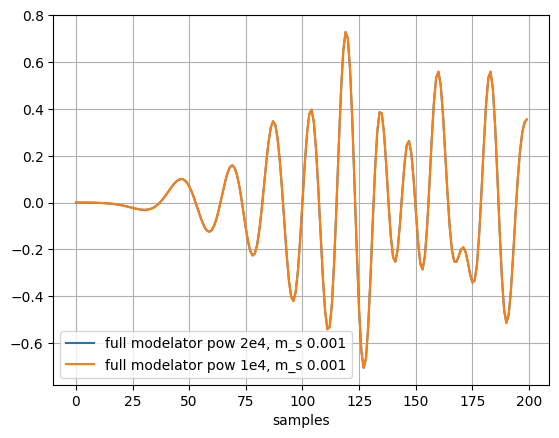

In [162]:
start_samples=500
end_samples=700

full_mod=h5py.File('batch_obj.hdf5') # power=1e4, modelling_step=0.001 sig_len=5000
full_mod_1=h5py.File('batch_obj_0.0005.hdf5') # power=1e4, modelling_step=0.0005 sig_len=5000
full_mod_2=h5py.File('batch_obj_0.001.hdf5')  # power=2e4, modelling_step=0.001 sig_len=5000

full_mod=full_mod['Channels'][sensor]['data'][0,2,start_samples:end_samples]
full_mod_1=full_mod_1['Channels'][sensor]['data'][0,2,start_samples:end_samples]
full_mod_2=full_mod_2['Channels'][sensor]['data'][0,2,start_samples:end_samples]

# sum_full_mod=np.sum(full_mod['Channels'][sensor]['data'][0,:3,:samples],axis=0)
# sum_full_mod_1=np.sum(full_mod_1['Channels'][sensor]['data'][0,:3,:samples],axis=0)
# sum_full_mod_2=np.sum(full_mod_2['Channels'][sensor]['data'][0,:3,:samples],axis=0)

#plt.plot(integral(signal.sosfilt(sos, sum_full_mod)),label="integral(sum, full modelator pow 1e4, m_s 0.001)")
#plt.plot(integral(signal.sosfilt(sos, sum_full_mod_1))+1,label="integral(sum, full modelator pow 1e4, m_s 0.0005)")
#plt.plot((integral(signal.sosfilt(sos, sum_full_mod_2))-1)/2,label="integral(sum, full modelator pow 2e4, m_s 0.001)")


#plt.plot(full_mod_1+1,label="full modelator pow 1e4, m_s 0.0005")
plt.plot(full_mod_2/2,label="full modelator pow 2e4, m_s 0.001")
plt.plot(full_mod,label="full modelator pow 1e4, m_s 0.001")


plt.xlabel('samples')
plt.grid()
plt.legend()